In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from torchvision.models import EfficientNet_B0_Weights

import matplotlib.pyplot as plt
from tqdm import tqdm

# ✅ Set Paths
DATASET_PATH = "E:\CLD_project\Final_CLD_data"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ✅ Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load Dataset
train_ds = datasets.ImageFolder(f"{DATASET_PATH}/train", transform=transform)
val_ds = datasets.ImageFolder(f"{DATASET_PATH}/val", transform=transform)
test_ds = datasets.ImageFolder(f"{DATASET_PATH}/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 124999, Val: 25000, Test: 5860


In [4]:
# ✅ Load Pretrained EfficientNet-B0
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(train_ds.classes))  # Adjust output layer

model = model.to(DEVICE)

# ✅ Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Lists to store metrics
train_losses, val_losses, train_accs, val_accs = [], [], [], []

In [5]:
# ✅ Training Loop
def train(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct/total)
        
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        val_acc, val_loss = evaluate(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

In [6]:
# ✅ Evaluation Function
def evaluate(model, loader):
    model.eval()
    correct, total, total_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total, total_loss / len(loader)


In [7]:
# ✅ Start Training
train(model, train_loader, val_loader, EPOCHS)

Epoch 1/3: 100%|██████████| 3907/3907 [29:41<00:00,  2.19it/s, acc=0.986, loss=0.000582]


Epoch 1/3 | Train Acc: 0.9864 | Val Acc: 0.9984 | Loss: 0.0462 | Val Loss: 0.0046


Epoch 2/3: 100%|██████████| 3907/3907 [33:12<00:00,  1.96it/s, acc=0.998, loss=0.0013]  


Epoch 2/3 | Train Acc: 0.9983 | Val Acc: 0.9994 | Loss: 0.0057 | Val Loss: 0.0013


Epoch 3/3: 100%|██████████| 3907/3907 [33:16<00:00,  1.96it/s, acc=0.999, loss=0.0024]  


Epoch 3/3 | Train Acc: 0.9989 | Val Acc: 0.9996 | Loss: 0.0037 | Val Loss: 0.0013


In [10]:
# ✅ Evaluate on Test Data
test_acc, test_loss = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:}")

Test Accuracy: 1.0


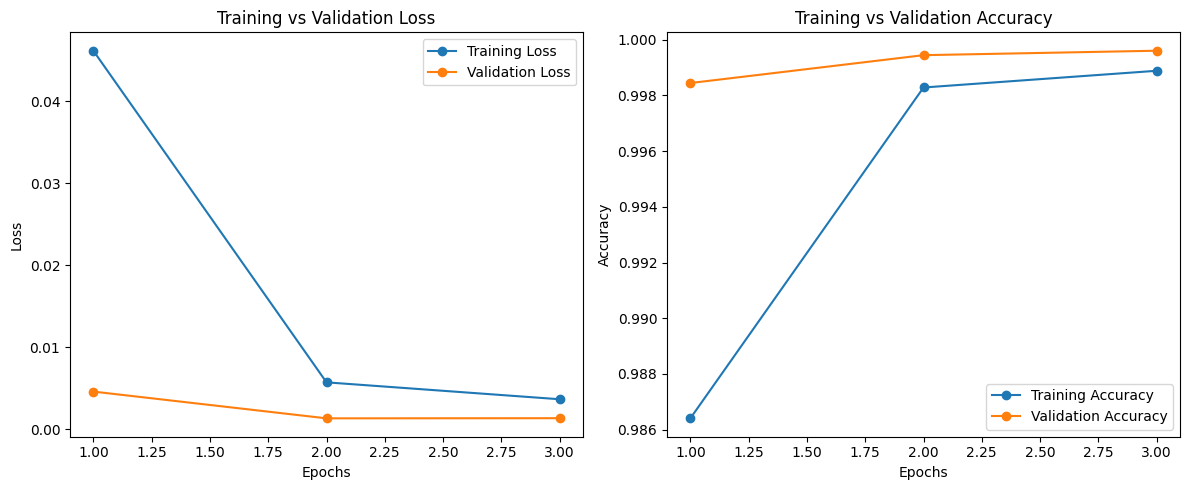

In [11]:
# ✅ Save EfficientNet Model
torch.save(model.state_dict(), "efficientnet_coffee.pth")

# ✅ Plot Training History
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accs, label="Training Accuracy", marker="o")
plt.plot(range(1, EPOCHS + 1), val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()